## Load and unzip weatherdata

In [110]:
import pickle
from pathlib import Path
from zipfile import ZipFile

import matplotlib.pyplot as plt
import pandas as pd
from kaggle.api.kaggle_api_extended import KaggleApi
import seaborn as sns


def load_weather_data():
  dataset_slug = "pschale/nyc-taxi-wunderground-weather"
  zip_name = "nyc-taxi-wunderground-weather.zip"
  csv_name = "weatherdata.csv"

  data_dir = Path("data")
  package_dir = Path("data_packages")

  zip_path = package_dir / zip_name
  csv_path = data_dir / csv_name
  pkl_path = data_dir / "weatherdata.pkl"

  # Schritt 0: Cache verwenden
  if pkl_path.is_file():
    with open(pkl_path, "rb") as f:
      return pickle.load(f)

  # Schritt 1: ZIP herunterladen, wenn sie nicht existiert
  if not zip_path.is_file():
    package_dir.mkdir(parents=True, exist_ok=True)
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files(dataset_slug, path=str(package_dir), unzip=False)

  # Schritt 2: Entpacken, falls CSV noch nicht existiert
  if not csv_path.is_file():
    data_dir.mkdir(parents=True, exist_ok=True)
    with ZipFile(zip_path, "r") as zip_ref:
      zip_ref.extract(csv_name, path=data_dir)

  # Schritt 3: CSV laden und Cache schreiben
  if not csv_path.is_file():
    raise FileNotFoundError(f"{csv_path} wurde nicht gefunden – Entpackung fehlgeschlagen.")

  df = pd.read_csv(csv_path)
  with open(pkl_path, "wb") as f:
    pickle.dump(df, f)

  return df


# Anwendung
weather_data_raw = load_weather_data()

# EDA  weather_data_raw

## General EDA

In [111]:
weather_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5175 entries, 0 to 5174
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    5175 non-null   object 
 1   temp         5175 non-null   float64
 2   windspeed    4036 non-null   float64
 3   humidity     5175 non-null   float64
 4   precip       5175 non-null   float64
 5   pressure     5041 non-null   float64
 6   conditions   5175 non-null   object 
 7   dailyprecip  5175 non-null   object 
 8   dailysnow    5175 non-null   object 
 9   fog          5175 non-null   int64  
 10  rain         5175 non-null   int64  
 11  snow         5175 non-null   int64  
dtypes: float64(5), int64(3), object(4)
memory usage: 485.3+ KB


- timestamp into datetime
- temp into celsius
- windspeed into kph
- precip into mm
- pressure into hpa
- dailyprecip into mm
- dailysnow into mm

In [112]:
weather_data_raw.describe()

,temp,windspeed,humidity,precip,pressure,fog,rain,snow
count,5175.000000,4036.000000,5175.000000,5175.000000,5041.000000,5175.000000,5175.000000,5175.000000
mean,50.922628,7.237314,58.503188,0.007484,29.975794,0.009275,0.082512,0.038261
std,16.102397,3.719488,20.780935,0.035944,0.235181,0.095870,0.275170,0.191844
min,-0.900000,3.500000,9.000000,0.000000,29.220000,0.000000,0.000000,0.000000
25%,37.900000,4.600000,42.000000,0.000000,29.820000,0.000000,0.000000,0.000000
50%,50.000000,6.900000,55.000000,0.000000,29.990000,0.000000,0.000000,0.000000
75%,64.000000,9.200000,78.000000,0.000000,30.130000,0.000000,0.000000,0.000000
max,90.000000,85.200000,100.000000,0.730000,30.620000,1.000000,1.000000,1.000000


In [113]:
weather_data_raw.describe(include='object')

,timestamp,conditions,dailyprecip,dailysnow
count,5175,5175,5175,5175
unique,5174,15,38,9
top,2016-03-13 00:51:00,Clear,0.00,0.00
freq,2,2216,2577,4491


- timestamp has one double

In [114]:
weather_data_raw.nunique()

timestamp      5174
temp            129
windspeed        21
humidity         89
precip           42
pressure        140
conditions       15
dailyprecip      38
dailysnow         9
fog               2
rain              2
snow              2
dtype: int64

In [115]:
weather_data_raw.isna().sum()

timestamp         0
temp              0
windspeed      1139
humidity          0
precip            0
pressure        134
conditions        0
dailyprecip       0
dailysnow         0
fog               0
rain              0
snow              0
dtype: int64

## EDA timestamp (datetime)

In [116]:
# Count entries per full hour (rounded down)
weather_data_raw['datetime'] = pd.to_datetime(weather_data_raw['timestamp'], errors='coerce')
weather_data_raw['datetime_hour'] = weather_data_raw['datetime'].dt.floor('h')

In [117]:
# Check for format consistency
weather_data_raw['datetime_hour'].astype(str).str.match(
    r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}$').all()

np.True_

In [118]:
# show sample
weather_data_raw['datetime'].head()

0   2016-01-01 00:51:00
1   2016-01-01 01:51:00
2   2016-01-01 02:51:00
3   2016-01-01 03:51:00
4   2016-01-01 04:51:00
Name: datetime, dtype: datetime64[ns]

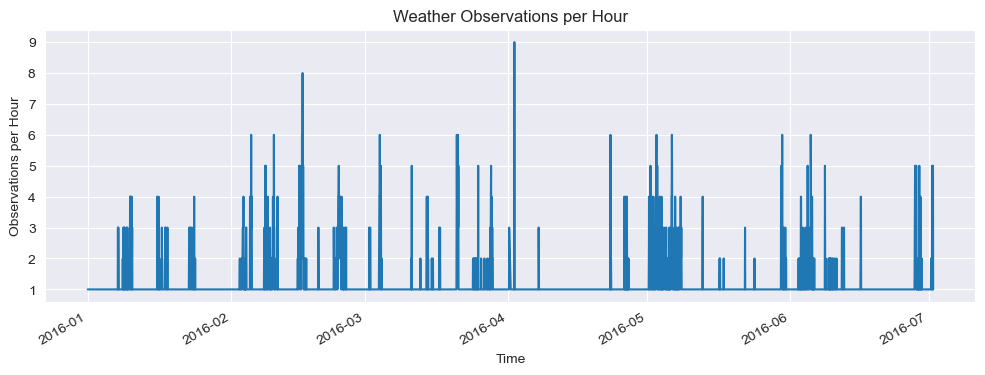

In [119]:


counts_per_hour = weather_data_raw['datetime_hour'].value_counts().sort_index()

# Plot time series frequency
plt.figure(figsize=(12, 4))
counts_per_hour.plot()
plt.title("Weather Observations per Hour")
plt.xlabel("Time")
plt.ylabel("Observations per Hour")
plt.grid(True)
plt.show()

- The timestamps are predominantly distributed hourly, with slight fluctuations.
- There are some dips in frequency; potentially missing hours.
- The data does not appear to be exactly on the hour (e.g. xx:51).

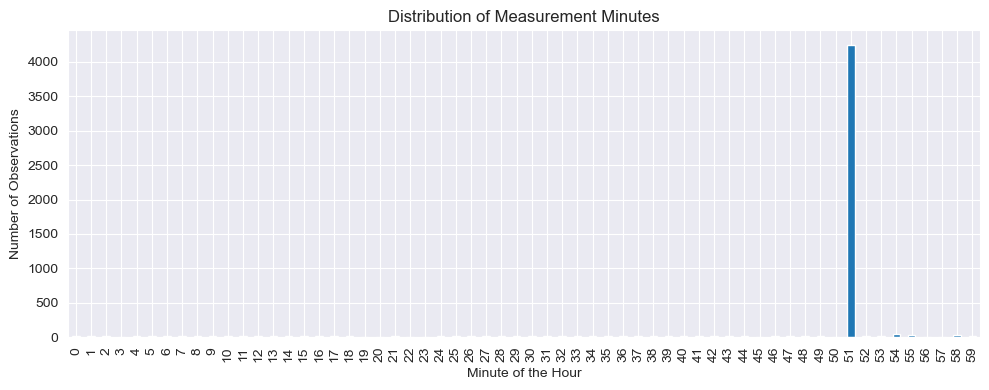

In [120]:
# Extract minute component from timestamp
weather_data_raw['datetime_minute'] = weather_data_raw['datetime'].dt.minute

# Count how many records fall into each minute of the hour
minute_distribution = weather_data_raw['datetime_minute'].value_counts().sort_index()

# Plot the distribution of measurement minutes
plt.figure(figsize=(10, 4))
minute_distribution.plot(kind='bar')
plt.title("Distribution of Measurement Minutes")
plt.xlabel("Minute of the Hour")
plt.ylabel("Number of Observations")
plt.grid(True)
plt.tight_layout()
plt.show()

- Minute 51 is by far the most frequent minute of measurement (over 4000 entries).
- All other minutes are rare or sporadic → probably exceptions, manual additions or other sources.

In [121]:
# Filter for rows measured at minute 51
weather_51 = weather_data_raw[weather_data_raw['datetime_minute'] == 51].copy()

# Count duplicated timestamps after filtering
duplicate_timestamps = weather_51['datetime'].duplicated().sum()

# Display all duplicated timestamp rows if any
duplicated_rows = weather_51[weather_51['datetime'].duplicated(keep=False)]

duplicate_timestamps, duplicated_rows.sort_values('datetime')

(np.int64(1),
                 timestamp  temp  windspeed  humidity  precip  pressure  \
 2092  2016-03-13 00:51:00  52.0        6.9      59.0     0.0     30.00   
 2093  2016-03-13 00:51:00  50.0        5.8      54.0     0.0     30.13   
 
       conditions dailyprecip dailysnow  fog  rain  snow            datetime  \
 2092       Clear           T      0.00    0     0     0 2016-03-13 00:51:00   
 2093  Light Rain           T      0.00    0     1     0 2016-03-13 00:51:00   
 
      datetime_hour  datetime_minute  
 2092    2016-03-13               51  
 2093    2016-03-13               51  )

In [122]:
# Aggregate to hourly level using mean for continuous values, max for binary flags
weather_data_raw = (
  weather_51.groupby('datetime_hour')
  .agg({
    'temp': 'mean',
    'windspeed': 'mean',
    'humidity': 'mean',
    'precip': 'sum',
    'pressure': 'mean',
    'dailyprecip': 'first',  # same within a day
    'dailysnow': 'first',
    'fog': 'max',
    'rain': 'max',
    'snow': 'max',
    'conditions': lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]  # most frequent
  })
  .reset_index()
)


- Exactly one timestamp is duplicated: 2016-03-13 00:51:00; Two different entries (Clear vs. Light
Rain), probably two weather sources or measurements.

## EDA temp

In [123]:
weather_data_raw['temp_C'] = (weather_data_raw['temp'] - 32) * 5 / 9
weather_data_raw['temp_C'].describe()

count    4246.000000
mean       10.631954
std         9.233852
min       -18.277778
25%         3.277778
50%        10.000000
75%        17.777778
max        32.222222
Name: temp_C, dtype: float64

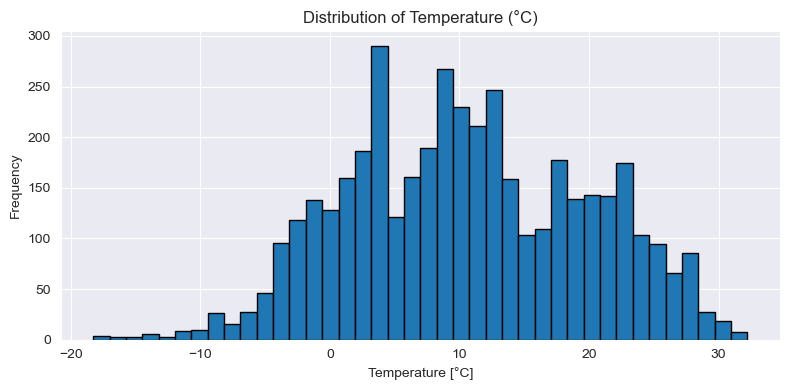

In [124]:
plt.figure(figsize=(8, 4))
weather_data_raw['temp_C'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of Temperature (°C)")
plt.xlabel("Temperature [°C]")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

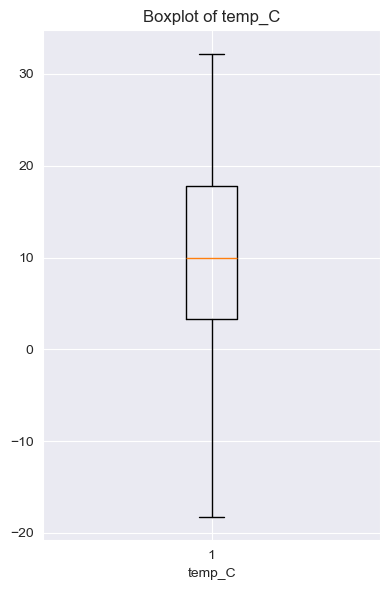

In [125]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data_raw["temp_C"].dropna())
plt.title(f"Boxplot of temp_C")
plt.xlabel("temp_C")
plt.tight_layout()
plt.show()

## EDA Windspeed

In [126]:
weather_data_raw['windspeed_kph'] = weather_data_raw['windspeed'] * 1.60934
weather_data_raw['windspeed_kph'].describe()

count    3357.000000
mean       11.426578
std         5.987670
min         5.632690
25%         7.402964
50%         9.334172
75%        14.805928
max       137.115768
Name: windspeed_kph, dtype: float64

In [127]:
weather_data_raw['windspeed_kph'].isna().sum()

np.int64(889)

In [128]:
weather_data_before_imputation = weather_data_raw
weather_data_raw.set_index('datetime_hour', inplace=True)
weather_data_raw['windspeed_kph'] = weather_data_raw['windspeed_kph'].interpolate(method='time')
weather_data_raw.reset_index(inplace=True)

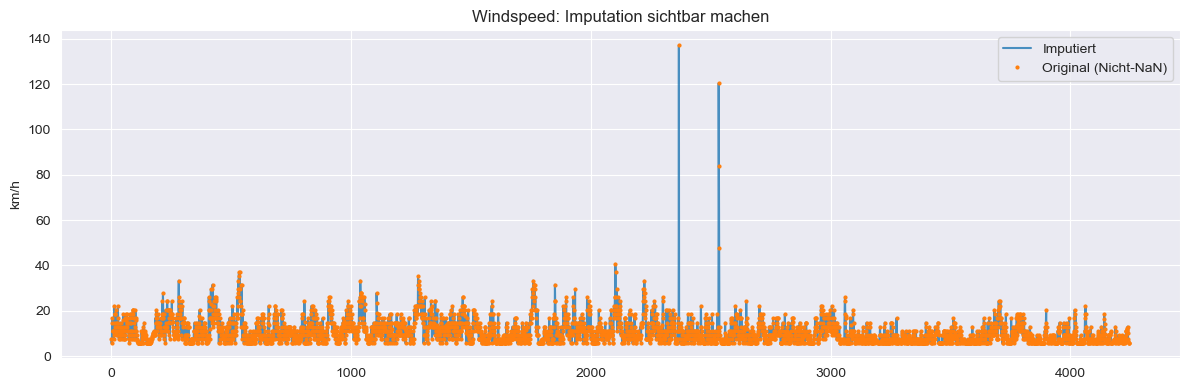

In [129]:
plt.figure(figsize=(12, 4))
weather_data_raw['windspeed_kph'].plot(label='Imputiert', alpha=0.8)
weather_data_raw['windspeed_kph'].where(weather_data_raw['windspeed_kph'].notna()).plot(style='o',
                                                                                        label='Original (Nicht-NaN)',
                                                                                        markersize=2)
plt.title('Windspeed: Imputation sichtbar machen')
plt.ylabel('km/h')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [130]:
before = weather_data_before_imputation['windspeed_kph']
after = weather_data_raw['windspeed_kph']

print("Mittelwert vorher:", before.mean())
print("Mittelwert nachher:", after.mean())
print("Standardabweichung vorher:", before.std())
print("Standardabweichung nachher:", after.std())

Mittelwert vorher: 10.790215960566204
Mittelwert nachher: 10.790215960566204
Standardabweichung vorher: 5.783660557081734
Standardabweichung nachher: 5.783660557081734


<Axes: title={'center': 'Stündliche Windspeed nach Imputation'}>

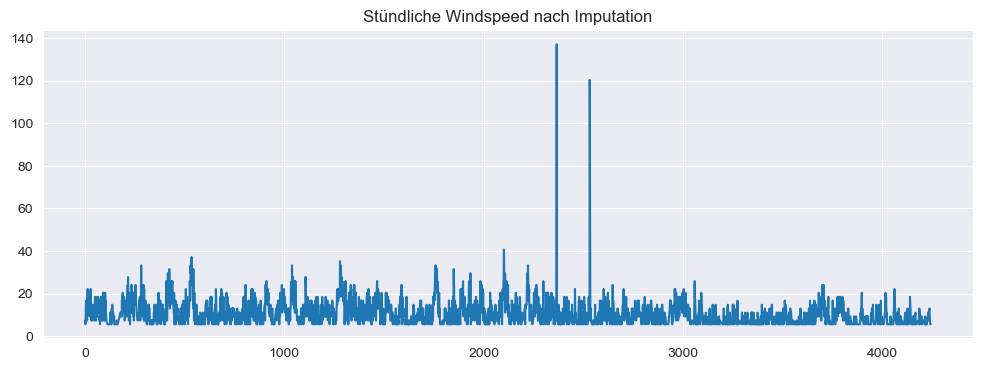

In [131]:
weather_data_raw['windspeed_kph'].plot(figsize=(12, 4),
                                       title="Stündliche Windspeed nach Imputation", grid=True)

In [132]:
weather_data_raw['windspeed_kph'].isna().sum()

np.int64(0)

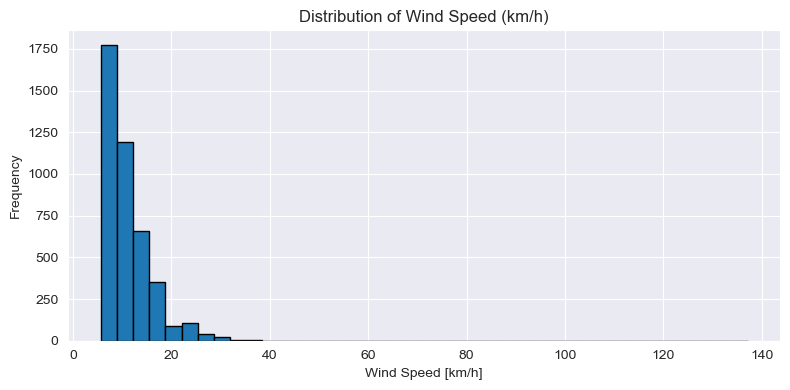

In [133]:
plt.figure(figsize=(8, 4))
weather_data_raw['windspeed_kph'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of Wind Speed (km/h)")
plt.xlabel("Wind Speed [km/h]")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

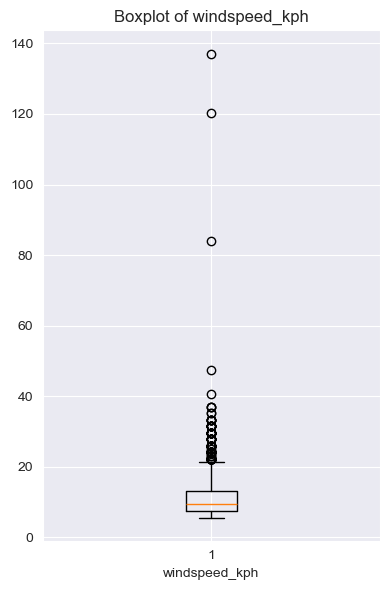

In [134]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data_raw["windspeed_kph"].dropna())
plt.title(f"Boxplot of windspeed_kph")
plt.xlabel("windspeed_kph")
plt.tight_layout()
plt.show()

- Most values lie between 5 and 25 km/h, which is typical for city-level weather.
- One extremely high value (137.12 km/h) may be an outlier.
- The variable appears well-behaved and usable without further transformation.

## EDA humidity

In [135]:
weather_data_raw['humidity'].describe()

count    4246.000000
mean       53.924753
std        18.900061
min         9.000000
25%        40.000000
50%        51.000000
75%        67.000000
max        97.000000
Name: humidity, dtype: float64

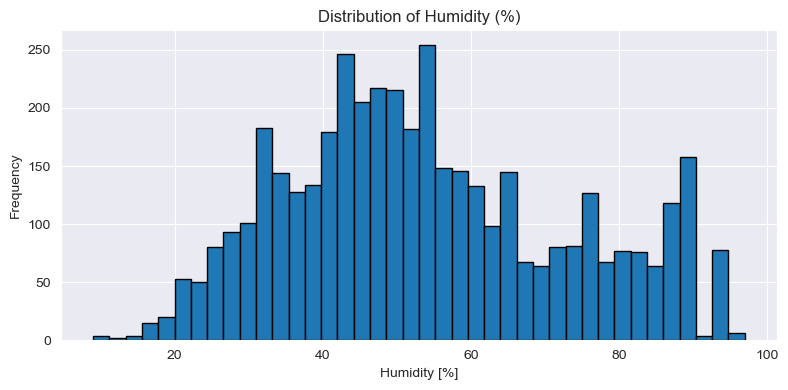

In [136]:
plt.figure(figsize=(8, 4))
weather_data_raw['humidity'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of Humidity (%)")
plt.xlabel("Humidity [%]")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

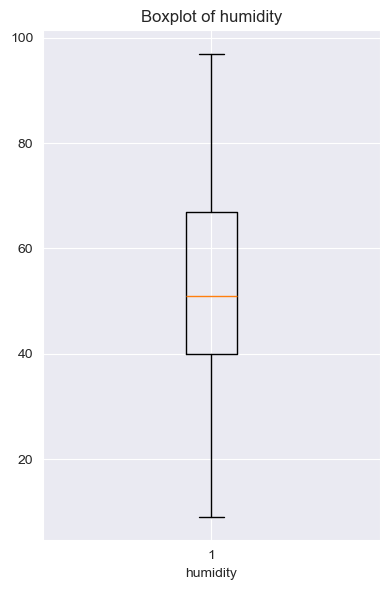

In [137]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data_raw["humidity"].dropna())
plt.title(f"Boxplot of humidity")
plt.xlabel("humidity")
plt.tight_layout()
plt.show()

- Values range from 9% to 97%.
- Most values lie between 40% and 70%.
- No anomalies or unrealistic entries.

## EDA precip

In [138]:
weather_data_raw['precip_mm'] = weather_data_raw['precip'] * 25.4
weather_data_raw['precip_mm'].describe()

count    4246.000000
mean        0.111327
std         0.731973
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        18.542000
Name: precip_mm, dtype: float64

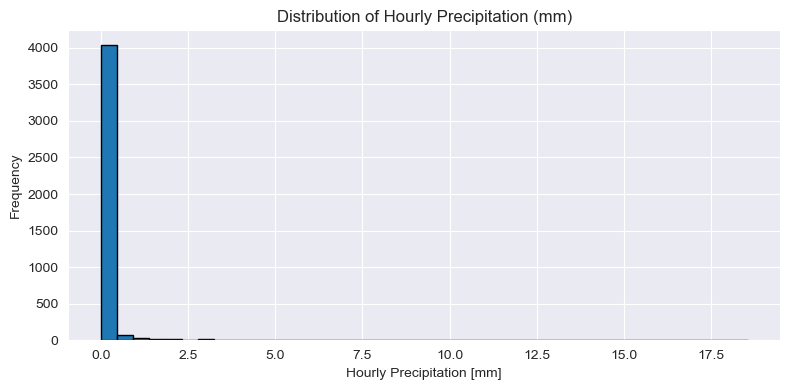

In [139]:
plt.figure(figsize=(8, 4))
weather_data_raw['precip_mm'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of Hourly Precipitation (mm)")
plt.xlabel("Hourly Precipitation [mm]")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

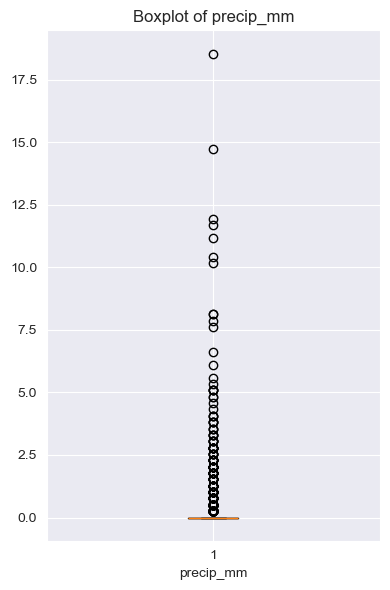

In [140]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data_raw["precip_mm"].dropna())
plt.title(f"Boxplot of precip_mm")
plt.xlabel("precip_mm")
plt.tight_layout()
plt.show()

Findings of the Exploration
- Most values are 0.0 (dry hours).
- Occasional rain events up to 18.5 mm.

Required Arrangements
- None. Consider binary flag creation (e.g. had_rain = precip_mm > 0).

## EDA pressure

In [141]:
weather_data_raw['pressure_hPa'] = weather_data_raw['pressure'] * 33.8639
weather_data_raw['pressure_hPa'].describe()

count    4226.000000
mean     1015.708376
std         7.919862
min       989.503158
25%      1010.160137
50%      1015.917000
75%      1020.657946
max      1036.912618
Name: pressure_hPa, dtype: float64

In [142]:
weather_data_raw['pressure_hPa'].isna().sum()

np.int64(20)

In [143]:
weather_data_before_imputation = weather_data_raw
weather_data_raw.set_index('datetime_hour', inplace=True)
weather_data_raw['pressure_hPa'] = weather_data_raw['pressure_hPa'].interpolate(method='time')
weather_data_raw.reset_index(inplace=True)

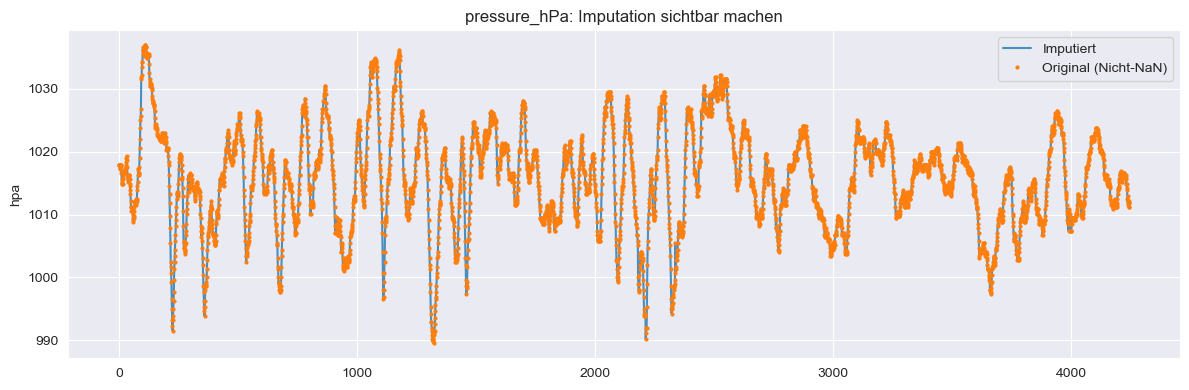

In [144]:
plt.figure(figsize=(12, 4))
weather_data_raw['pressure_hPa'].plot(label='Imputiert', alpha=0.8)
weather_data_raw['pressure_hPa'].where(weather_data_raw['pressure_hPa'].notna()).plot(style='o',
                                                                                      label='Original (Nicht-NaN)',
                                                                                      markersize=2)
plt.title('pressure_hPa: Imputation sichtbar machen')
plt.ylabel('hpa')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [145]:
before = weather_data_before_imputation['pressure_hPa']
after = weather_data_raw['pressure_hPa']

print("Mittelwert vorher:", before.mean())
print("Mittelwert nachher:", after.mean())
print("Standardabweichung vorher:", before.std())
print("Standardabweichung nachher:", after.std())

Mittelwert vorher: 1015.737866383567
Mittelwert nachher: 1015.737866383567
Standardabweichung vorher: 7.912895702048066
Standardabweichung nachher: 7.912895702048066


<Axes: title={'center': 'Stündliche pressure_hPa nach Imputation'}>

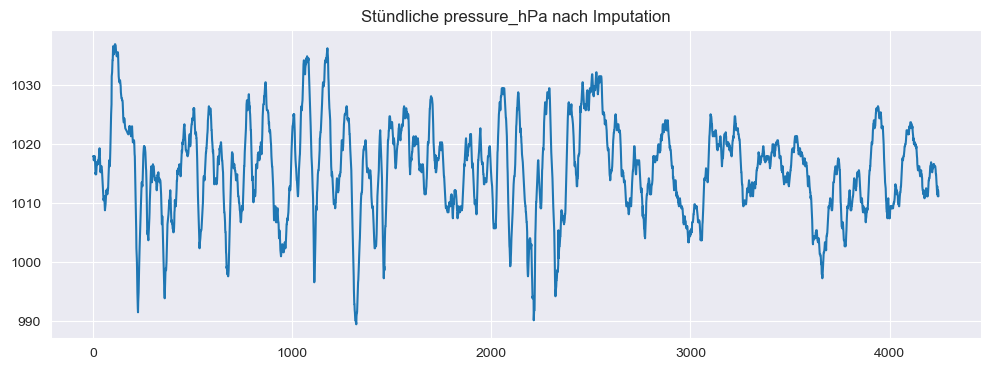

In [146]:
weather_data_raw['pressure_hPa'].plot(figsize=(12, 4),
                                      title="Stündliche pressure_hPa nach Imputation", grid=True)

In [147]:
weather_data_raw['pressure_hPa'].isna().sum()

np.int64(0)

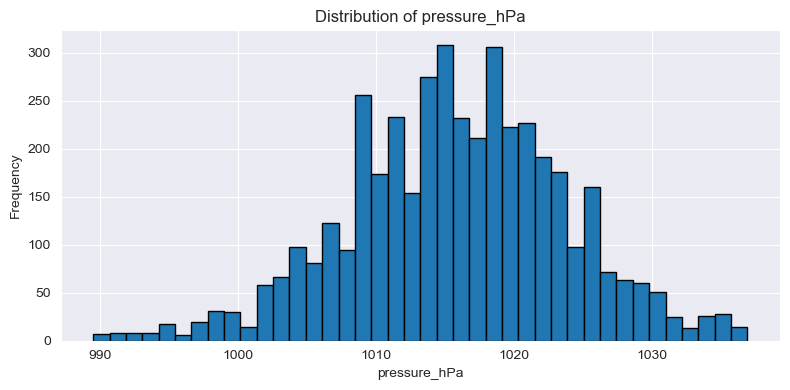

In [148]:
plt.figure(figsize=(8, 4))
weather_data_raw['pressure_hPa'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of pressure_hPa")
plt.xlabel("pressure_hPa")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

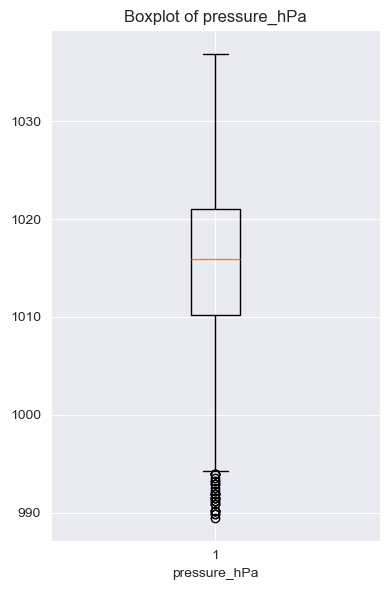

In [149]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data_raw["pressure_hPa"].dropna())
plt.title(f"Boxplot of pressure_hPa")
plt.xlabel("pressure_hPa")
plt.tight_layout()
plt.show()

## EDA dailyrain

In [150]:
weather_data_raw['dailyprecip'].value_counts()

dailyprecip
0.00    2466
T        403
0.01     185
0.05      96
0.04      96
0.09      94
0.02      72
0.16      72
0.24      48
0.45      48
0.06      48
0.22      24
0.91      24
0.40      24
0.38      24
0.18      24
0.54      24
0.61      24
0.20      24
0.12      24
1.65      24
0.29      24
0.07      24
0.14      24
1.22      24
0.30      24
0.03      24
1.01      24
0.53      24
0.73      24
2.31      24
1.80      24
0.83      24
0.47      23
0.11      23
0.44      23
0.15      21
Name: count, dtype: int64

In [151]:
# Ersetze 'T' durch einen minimalen Wert
weather_data_raw['dailyprecip'] = weather_data_raw['dailyprecip'].replace('T', '0.001')

In [152]:
weather_data_raw['dailyprecip'] = weather_data_raw['dailyprecip'].astype(float)

In [153]:
weather_data_raw['precip_daily_mm'] = weather_data_raw['dailyprecip'] * 25.4

In [154]:
weather_data_raw['precip_daily_mm'].isna().sum()

np.int64(0)

In [155]:
weather_data_raw['precip_daily_mm'].describe()

count    4246.000000
mean        2.645303
std         7.782427
min         0.000000
25%         0.000000
50%         0.000000
75%         1.016000
max        58.674000
Name: precip_daily_mm, dtype: float64

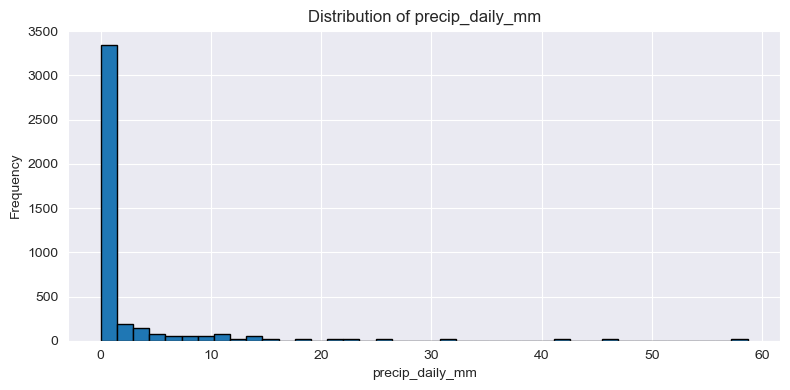

In [156]:
plt.figure(figsize=(8, 4))
weather_data_raw['precip_daily_mm'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of precip_daily_mm")
plt.xlabel("precip_daily_mm")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

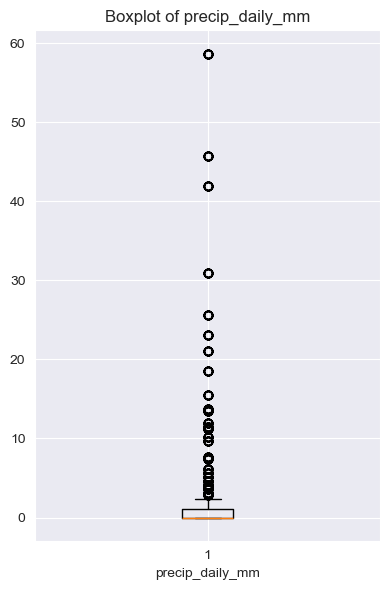

In [157]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data_raw["precip_daily_mm"].dropna())
plt.title(f"Boxplot of precip_daily_mm")
plt.xlabel("precip_daily_mm")
plt.tight_layout()
plt.show()

- ...

## EDA dailysnow

In [158]:
weather_data_raw['dailysnow'].value_counts()

dailysnow
0.00     3771
T         285
0.40       47
0.20       24
26.60      24
2.50       24
0.10       24
0.50       24
1.40       23
Name: count, dtype: int64

In [159]:
weather_data_raw['dailysnow'] = weather_data_raw['dailysnow'].replace('T', '0.001')
weather_data_raw['dailysnow'] = weather_data_raw['dailysnow'].astype(float)

In [160]:
weather_data_raw['precip_snow_mm'] = weather_data_raw['dailysnow'] * 25.4
weather_data_raw['precip_snow_mm'].describe()

count    4246.000000
mean        4.599548
std        50.907600
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       675.640000
Name: precip_snow_mm, dtype: float64

In [161]:
weather_data_raw['precip_snow_mm'].isna().sum()

np.int64(0)

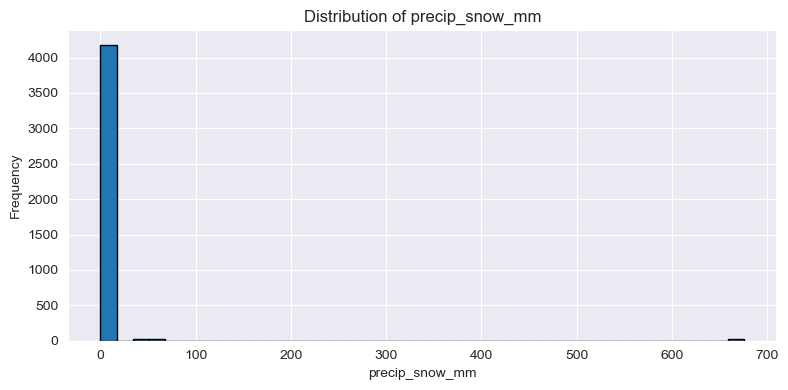

In [162]:
plt.figure(figsize=(8, 4))
weather_data_raw['precip_snow_mm'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of precip_snow_mm")
plt.xlabel("precip_snow_mm")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

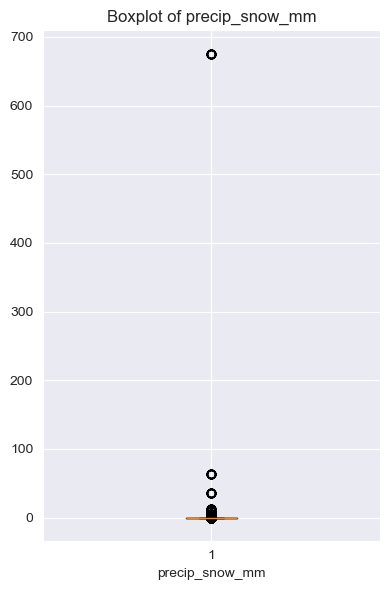

In [163]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data_raw["precip_snow_mm"].dropna())
plt.title(f"Boxplot of precip_snow_mm")
plt.xlabel("precip_snow_mm")
plt.tight_layout()
plt.show()

EDA fog, rain, snow

In [164]:
weather_data_raw['fog'].value_counts()

fog
0    4219
1      27
Name: count, dtype: int64

In [165]:
weather_data_raw['rain'].value_counts()

rain
0    4063
1     183
Name: count, dtype: int64

In [166]:
weather_data_raw['snow'].value_counts()

snow
0    4178
1      68
Name: count, dtype: int64

## EDA Conditions

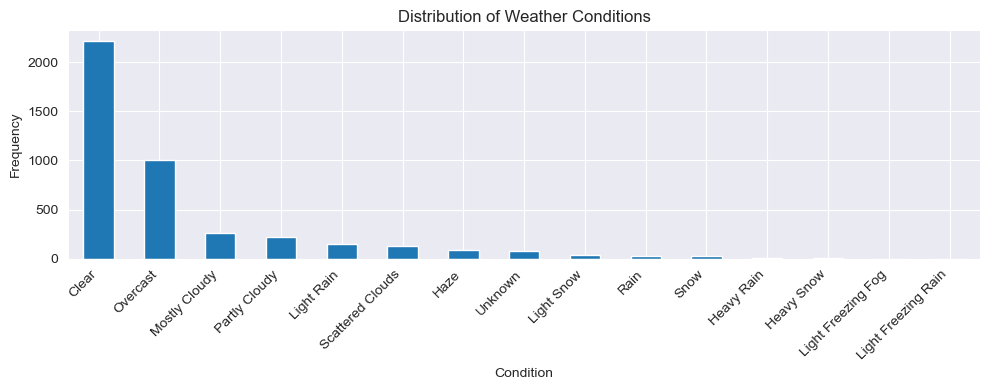

In [167]:
condition_counts = weather_data_raw['conditions'].value_counts()

plt.figure(figsize=(10, 4))
condition_counts.plot(kind='bar')
plt.title("Distribution of Weather Conditions")
plt.xlabel("Condition")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

- Most common condition is Clear (2215 times), followed by Overcast (1000).
- Some conditions occur only a few times, e.g., Heavy Snow, Light Freezing Fog.
- Unknown appears 83 times and may indicate missing or invalid sensor data.

# Classify / EDA  Weather Conditions

## Classify / EDA –  rain intensity

In [168]:
# 1. Human-readable rain classification
def classify_rain_label(x):
  if x >= 30:
    return "extreme rain"
  elif x >= 15:
    return "very heavy rain"
  elif x >= 7.5:
    return "heavy rain"
  elif x >= 2.5:
    return "moderate rain"
  elif x > 0:
    return "light rain"
  else:
    return "no rain"


weather_data_raw['rain_class'] = weather_data_raw['precip_mm'].apply(classify_rain_label)

In [169]:

# 2. Ordinal encoding for machine learning
rain_mapping = {
  "no rain": 0,
  "light rain": 1,
  "moderate rain": 2,
  "heavy rain": 3,
  "very heavy rain": 4,
  "extreme rain": 5
}

weather_data_raw['rain_class_code'] = weather_data_raw['rain_class'].map(rain_mapping)

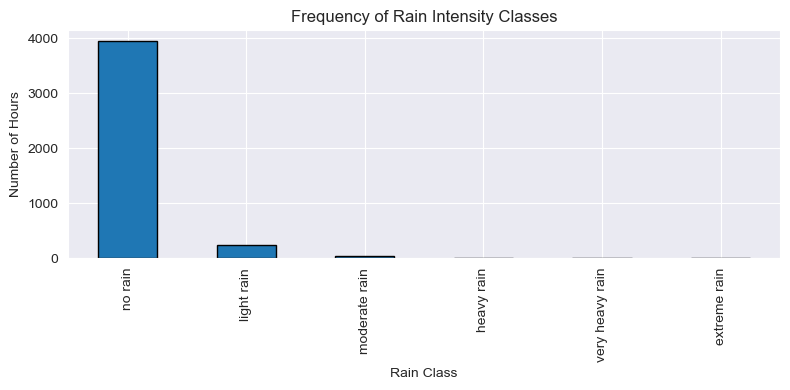

In [170]:
rain_counts = weather_data_raw['rain_class'].value_counts().reindex([
    "no rain", "light rain", "moderate rain", "heavy rain", "very heavy rain", "extreme rain"
])

rain_counts.plot(kind='bar', edgecolor='black', figsize=(8, 4))
plt.title("Frequency of Rain Intensity Classes")
plt.xlabel("Rain Class")
plt.ylabel("Number of Hours")
plt.grid(True)
plt.tight_layout()
plt.show()

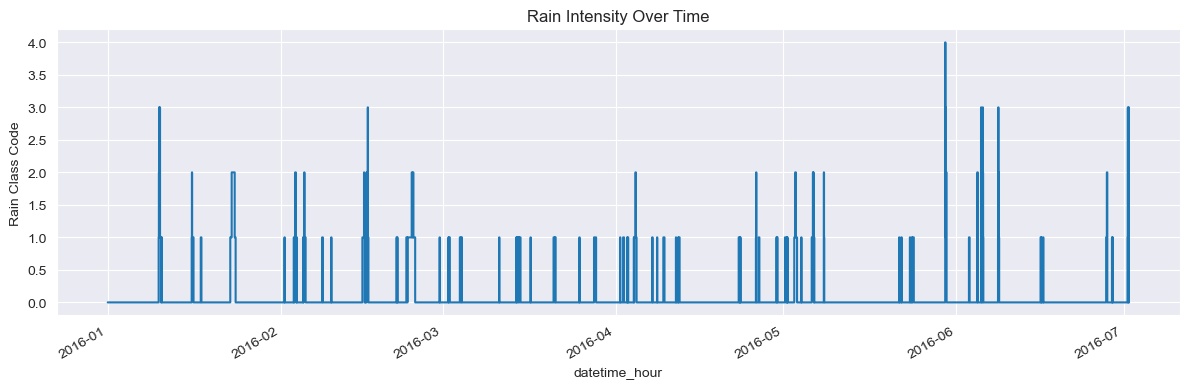

In [171]:
rain_time_series = weather_data_raw.set_index('datetime_hour')['rain_class_code']

plt.figure(figsize=(12, 4))
rain_time_series.plot(drawstyle='steps-post')
plt.title("Rain Intensity Over Time")
plt.ylabel("Rain Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

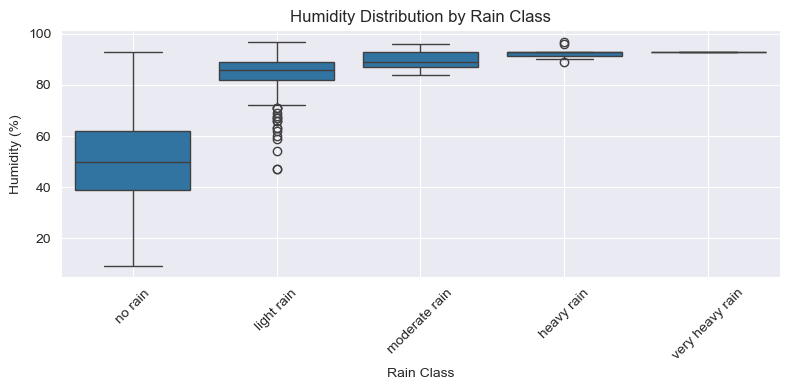

In [172]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=weather_data_raw, x='rain_class', y='humidity')
plt.title("Humidity Distribution by Rain Class")
plt.xlabel("Rain Class")
plt.ylabel("Humidity (%)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Classify / EDA – snow intensity

In [173]:
# 1. Human-readable snow classification based on conditions
def classify_snow_label(x):
  if x == "Light Snow":
    return "light snow"
  elif x == "Snow":
    return "snow"
  elif x == "Heavy Snow":
    return "heavy snow"
  else:
    return "no snow"


weather_data_raw['snow_class'] = weather_data_raw['conditions'].apply(classify_snow_label)

In [174]:
# 2. Ordinal encoding for ML
snow_mapping = {
  "no snow": 0,
  "light snow": 1,
  "snow": 2,
  "heavy snow": 3
}

weather_data_raw['snow_class_code'] = weather_data_raw['snow_class'].map(snow_mapping)

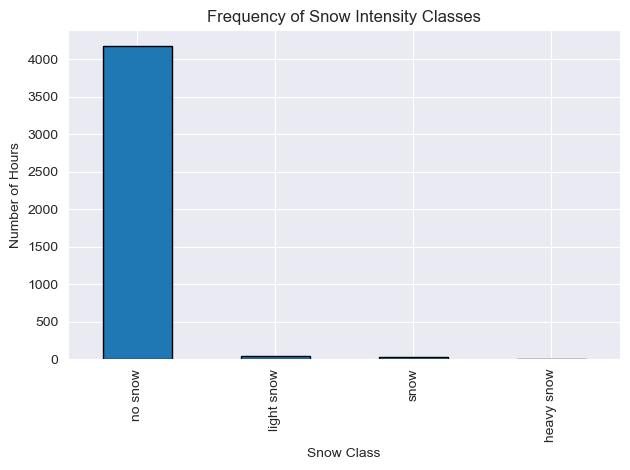

In [175]:
weather_data_raw['snow_class'].value_counts().reindex([
    "no snow", "light snow", "snow", "heavy snow"
]).plot(kind='bar', edgecolor='black')
plt.title("Frequency of Snow Intensity Classes")
plt.xlabel("Snow Class")
plt.ylabel("Number of Hours")
plt.grid(True)
plt.tight_layout()
plt.show()

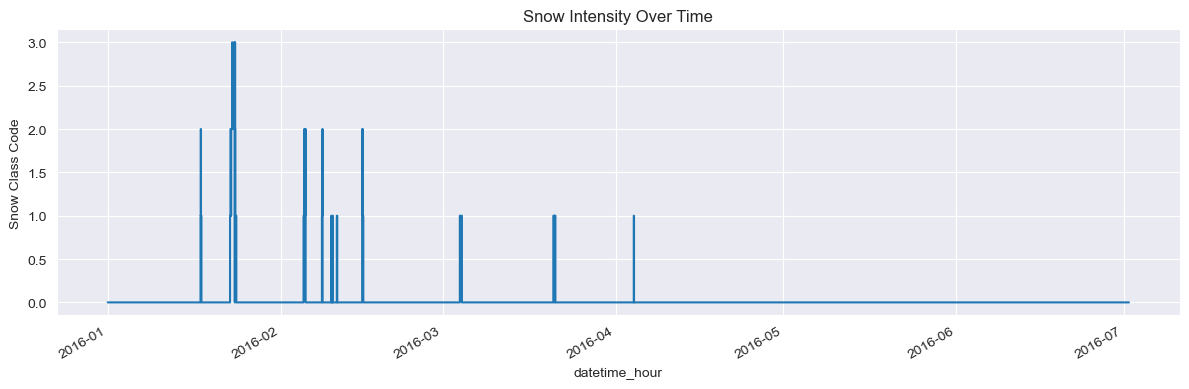

In [176]:
# Time series: Snow Class Code
plt.figure(figsize=(12, 4))
weather_data_raw.set_index('datetime_hour')['snow_class_code'].plot(drawstyle='steps-post')
plt.title("Snow Intensity Over Time")
plt.ylabel("Snow Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

## Classify / EDA –  cloud intensity

In [177]:
# 1. Human-readable cloud classification based on conditions
def classify_cloud_label(x):
  if x == "Clear":
    return "clear"  # 0–10%
  elif x == "Scattered Clouds":
    return "scattered clouds"  # ~25–50%
  elif x == "Partly Cloudy":
    return "partly cloudy"  # ~20–60%
  elif x == "Mostly Cloudy":
    return "mostly cloudy"  # ~60–90%
  elif x == "Overcast":
    return "overcast"  # >90%
  else:
    return "unknown"


weather_data_raw['cloud_class'] = weather_data_raw['conditions'].apply(classify_cloud_label)

In [178]:

# 2. Ordinal encoding for ML
cloud_mapping = {
  "unknown": 0,
  "clear": 1,
  "scattered clouds": 2,
  "partly cloudy": 3,
  "mostly cloudy": 4,
  "overcast": 5
}

weather_data_raw['cloud_class_code'] = weather_data_raw['cloud_class'].map(cloud_mapping)

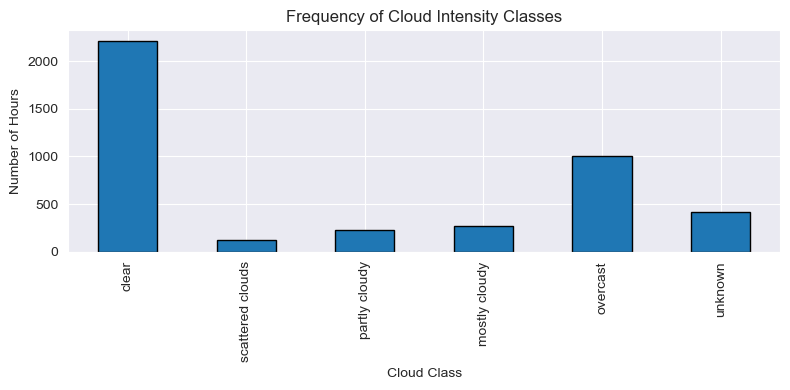

In [179]:
# Bar plot: Frequency of Cloud Classes
cloud_counts = weather_data_raw['cloud_class'].value_counts().reindex([
    "clear", "scattered clouds", "partly cloudy", "mostly cloudy", "overcast", "unknown"
])
cloud_counts.plot(kind='bar', edgecolor='black', figsize=(8, 4))
plt.title("Frequency of Cloud Intensity Classes")
plt.xlabel("Cloud Class")
plt.ylabel("Number of Hours")
plt.grid(True)
plt.tight_layout()
plt.show()

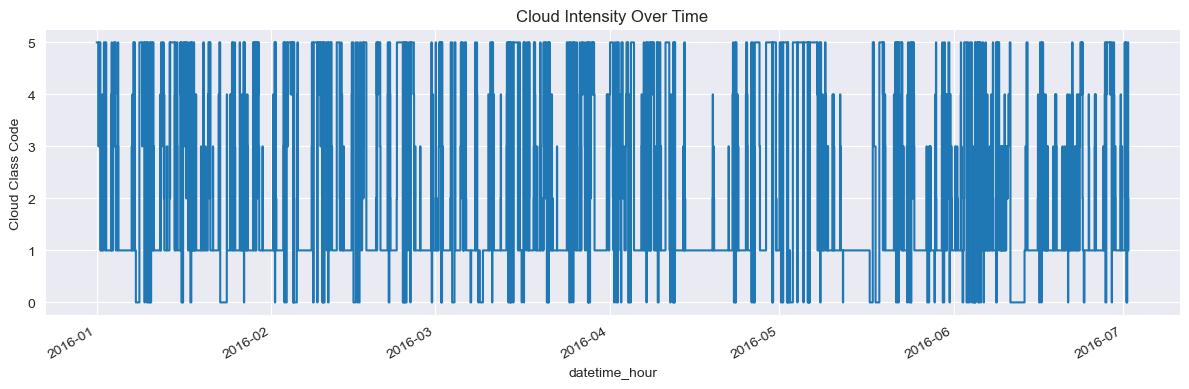

In [180]:
# Time series: Cloud Class Code
plt.figure(figsize=(12, 4))
weather_data_raw.set_index('datetime_hour')['cloud_class_code'].plot(drawstyle='steps-post')
plt.title("Cloud Intensity Over Time")
plt.ylabel("Cloud Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Humidity by Cloud Class')

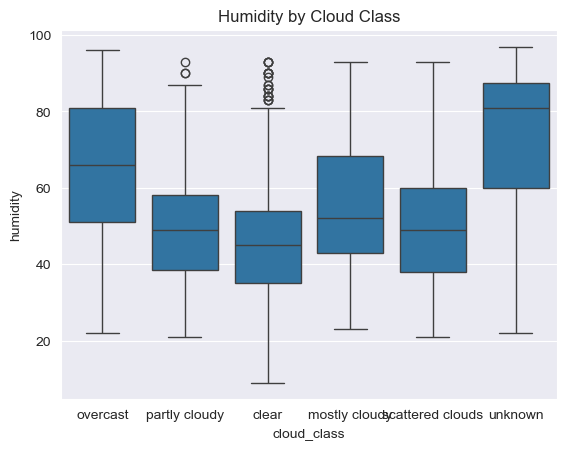

In [181]:
sns.boxplot(data=weather_data_raw, x='cloud_class', y='humidity')
plt.title("Humidity by Cloud Class")

## Classify / EDA –  haze intensity

In [182]:
# 1. Human-readable haze classification
def classify_haze_label(x):
  return "haze" if x == "Haze" else "no haze"


weather_data_raw['hazy_class'] = weather_data_raw['conditions'].apply(classify_haze_label)

In [183]:

# 2. Binary encoding for ML
haze_mapping = {
  "no haze": 0,
  "haze": 1
}

weather_data_raw['hazy_class_code'] = weather_data_raw['hazy_class'].map(haze_mapping)

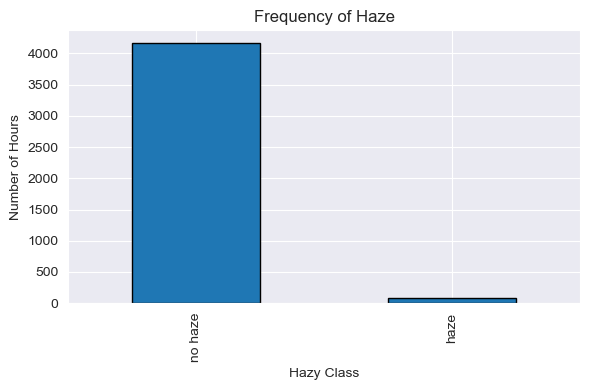

In [184]:
# Bar plot: Frequency of Haze
hazy_counts = weather_data_raw['hazy_class'].value_counts().reindex(["no haze", "haze"])
hazy_counts.plot(kind='bar', edgecolor='black', figsize=(6, 4))
plt.title("Frequency of Haze")
plt.xlabel("Hazy Class")
plt.ylabel("Number of Hours")
plt.grid(True)
plt.tight_layout()
plt.show()

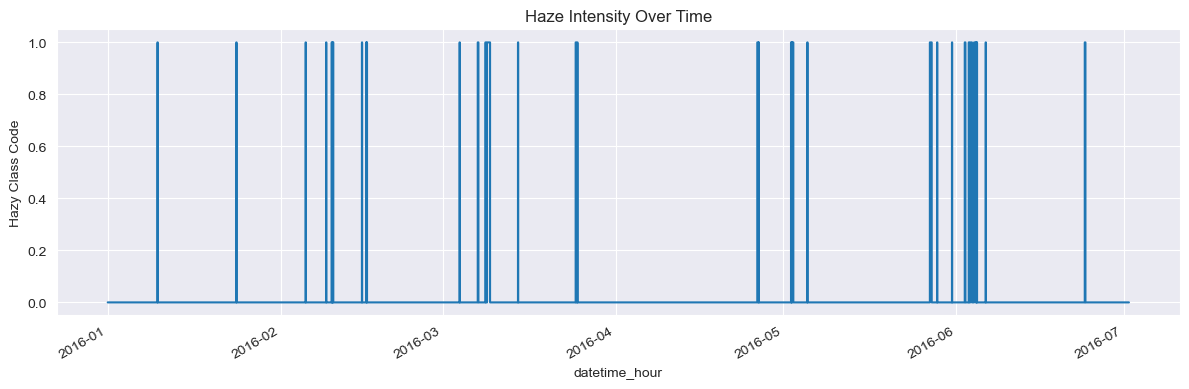

In [185]:
# Time series: Hazy Class Code
plt.figure(figsize=(12, 4))
weather_data_raw.set_index('datetime_hour')['hazy_class_code'].plot(drawstyle='steps-post')
plt.title("Haze Intensity Over Time")
plt.ylabel("Hazy Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

## Classify / EDA –  freezing fog or rain

In [186]:
# 1. Human-readable freezing condition classification
def classify_freezing_label(x):
  if x == "Light Freezing Fog":
    return "light freezing fog"
  elif x == "Light Freezing Rain":
    return "light freezing rain"
  else:
    return "none"


weather_data_raw['freezing_class'] = weather_data_raw['conditions'].apply(classify_freezing_label)

In [187]:


# 2. Ordinal encoding for ML
freezing_mapping = {
  "none": 0,
  "light freezing rain": 1,
  "light freezing fog": 2
}

weather_data_raw['freezing_class_code'] = weather_data_raw['freezing_class'].map(freezing_mapping)

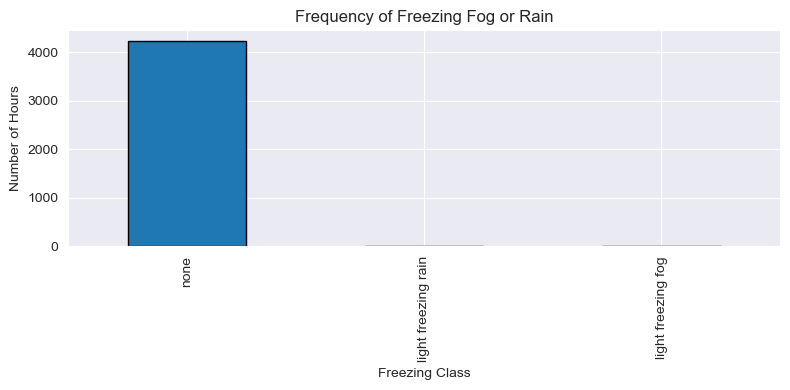

In [188]:
# Bar plot: Frequency of Freezing Classes
freezing_counts = weather_data_raw['freezing_class'].value_counts().reindex([
    "none", "light freezing rain", "light freezing fog"
])
freezing_counts.plot(kind='bar', edgecolor='black', figsize=(8, 4))
plt.title("Frequency of Freezing Fog or Rain")
plt.xlabel("Freezing Class")
plt.ylabel("Number of Hours")
plt.grid(True)
plt.tight_layout()
plt.show()

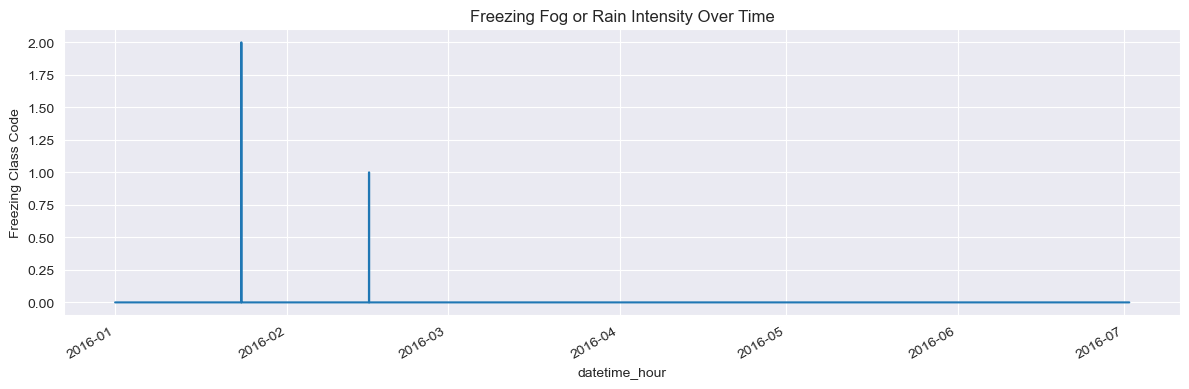

In [189]:
# Time series: Freezing Class Code
plt.figure(figsize=(12, 4))
weather_data_raw.set_index('datetime_hour')['freezing_class_code'].plot(drawstyle='steps-post')
plt.title("Freezing Fog or Rain Intensity Over Time")
plt.ylabel("Freezing Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

## Classify / EDA –  fog

In [190]:
# 1. Human-readable fog classification
def classify_fog_label(x):
  return "fog" if x == 1 else "no fog"


weather_data_raw['fog_class'] = weather_data_raw['fog'].apply(classify_fog_label)

In [191]:
# 2. Binary encoding for ML
fog_mapping = {
  "no fog": 0,
  "fog": 1
}

weather_data_raw['fog_class_code'] = weather_data_raw['fog_class'].map(fog_mapping)

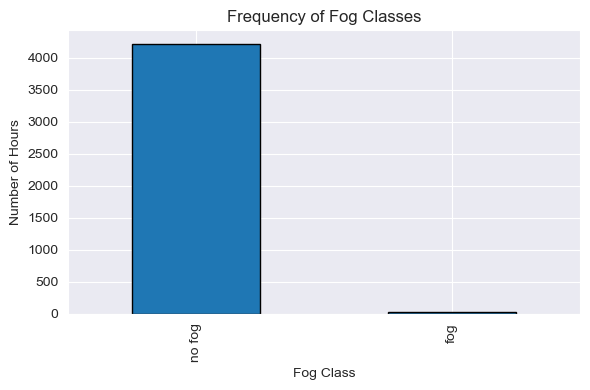

In [192]:
# Bar plot: Frequency of Fog Classes
fog_counts = weather_data_raw['fog_class'].value_counts().reindex(["no fog", "fog"])
fog_counts.plot(kind='bar', edgecolor='black', figsize=(6, 4))
plt.title("Frequency of Fog Classes")
plt.xlabel("Fog Class")
plt.ylabel("Number of Hours")
plt.grid(True)
plt.tight_layout()
plt.show()

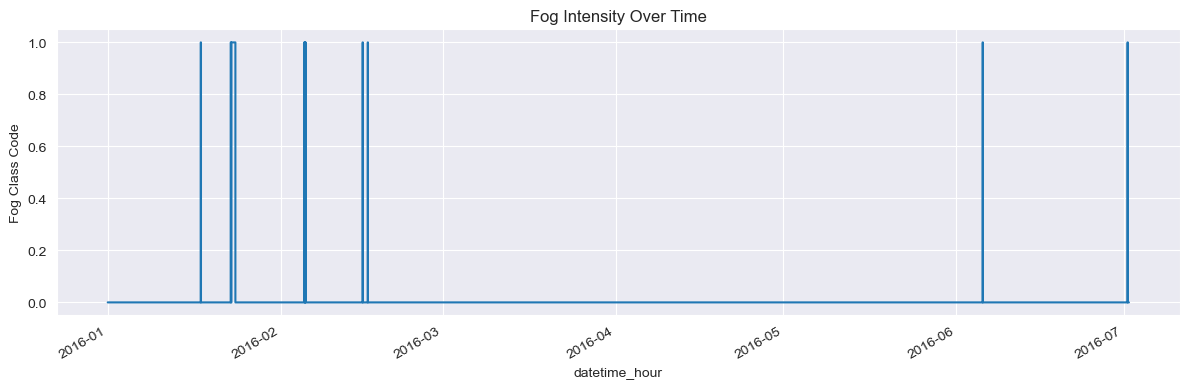

In [193]:
# Time series: Fog Class Code
plt.figure(figsize=(12, 4))
weather_data_raw.set_index('datetime_hour')['fog_class_code'].plot(drawstyle='steps-post')
plt.title("Fog Intensity Over Time")
plt.ylabel("Fog Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

## Classify / EDA –  temp itensity

In [194]:
# 1. Human-readable temperature classification
def classify_temp_label(t):
  if t < -5:
    return "very cold"
  elif t < 5:
    return "cold"
  elif t < 15:
    return "cool"
  elif t < 20:
    return "mild"
  elif t < 25:
    return "warm"
  else:
    return "hot"


weather_data_raw['temp_class'] = weather_data_raw['temp_C'].apply(classify_temp_label)

In [195]:


# 2. Ordinal encoding for ML
temp_mapping = {
  "very cold": 0,
  "cold": 1,
  "cool": 2,
  "mild": 3,
  "warm": 4,
  "hot": 5
}

weather_data_raw['temp_class_code'] = weather_data_raw['temp_class'].map(temp_mapping)

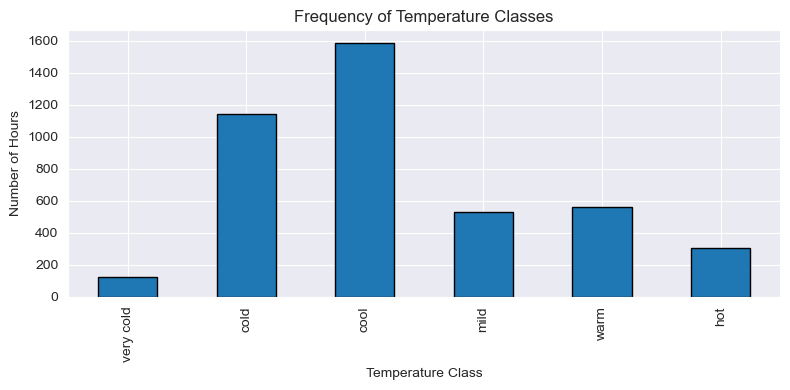

In [196]:
# Bar plot: Frequency of Temperature Classes
temp_counts = weather_data_raw['temp_class'].value_counts().reindex([
  "very cold", "cold", "cool", "mild", "warm", "hot"
])

temp_counts.plot(kind='bar', edgecolor='black', figsize=(8, 4))
plt.title("Frequency of Temperature Classes")
plt.xlabel("Temperature Class")
plt.ylabel("Number of Hours")
plt.grid(True)
plt.tight_layout()
plt.show()

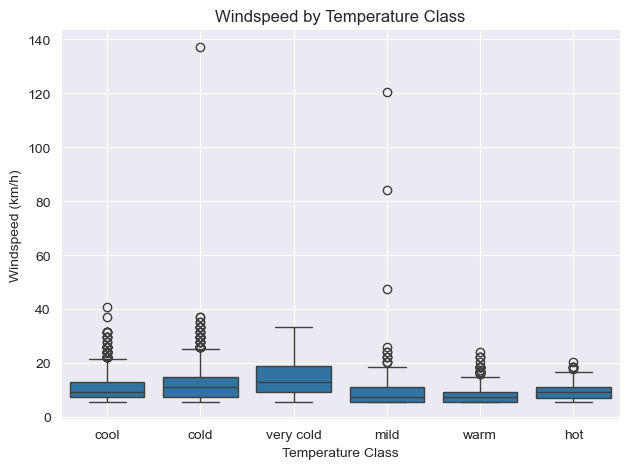

In [197]:

# Boxplot: Windspeed by Temperature Class
sns.boxplot(data=weather_data_raw, x='temp_class', y='windspeed_kph')
plt.title("Windspeed by Temperature Class")
plt.xlabel("Temperature Class")
plt.ylabel("Windspeed (km/h)")
plt.grid(True)
plt.tight_layout()
plt.show()

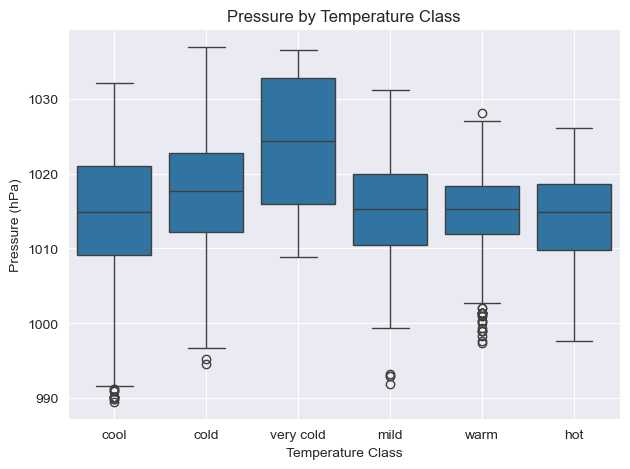

In [198]:

# Boxplot: Pressure by Temperature Class
sns.boxplot(data=weather_data_raw, x='temp_class', y='pressure_hPa')
plt.title("Pressure by Temperature Class")
plt.xlabel("Temperature Class")
plt.ylabel("Pressure (hPa)")
plt.grid(True)
plt.tight_layout()
plt.show()

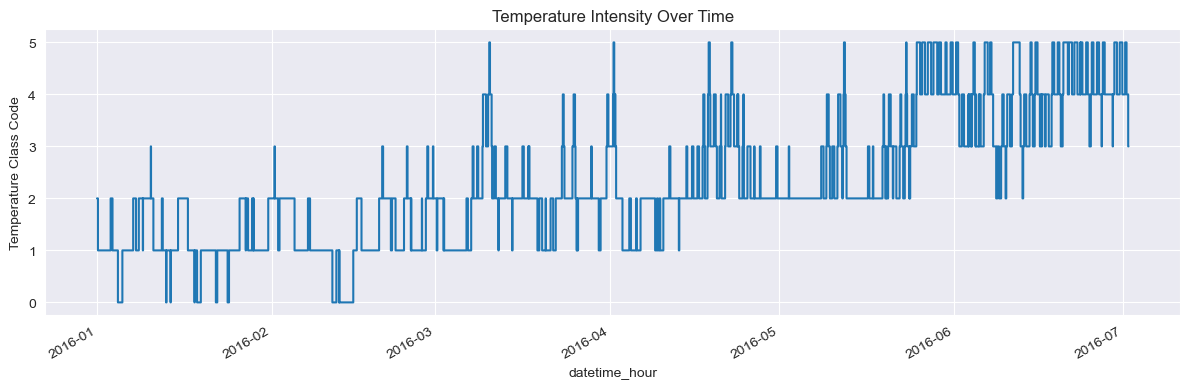

In [199]:

# Time series: Temperature Class Code over Time
plt.figure(figsize=(12, 4))
weather_data_raw.set_index('datetime_hour')['temp_class_code'].plot(drawstyle='steps-post')
plt.title("Temperature Intensity Over Time")
plt.ylabel("Temperature Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

## Classify / EDA –  windspeed itensity

In [200]:
# 1. Human-readable windspeed classification (Beaufort-based)
def classify_wind_label(speed):
  if speed < 1:
    return "calm"
  elif speed < 12:
    return "light air"
  elif speed < 29:
    return "light breeze"
  elif speed < 50:
    return "moderate breeze"
  elif speed < 75:
    return "strong breeze"
  else:
    return "stormy"


weather_data_raw['windspeed_class'] = weather_data_raw['windspeed_kph'].apply(classify_wind_label)

In [201]:
# 2. Ordinal encoding for ML
windspeed_mapping = {
  "calm": 0,
  "light air": 1,
  "light breeze": 2,
  "moderate breeze": 3,
  "strong breeze": 4,
  "stormy": 5
}

weather_data_raw['windspeed_class_code'] = weather_data_raw['windspeed_class'].map(
    windspeed_mapping)

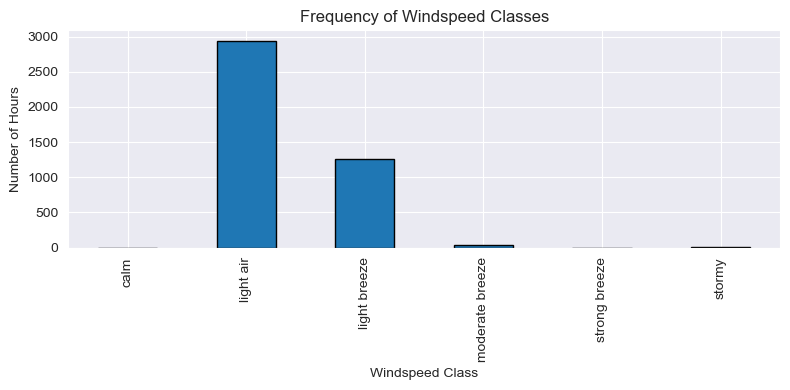

In [202]:
# Bar plot: Frequency of Windspeed Classes
windspeed_counts = weather_data_raw['windspeed_class'].value_counts().reindex([
    "calm", "light air", "light breeze", "moderate breeze", "strong breeze", "stormy"
])

windspeed_counts.plot(kind='bar', edgecolor='black', figsize=(8, 4))
plt.title("Frequency of Windspeed Classes")
plt.xlabel("Windspeed Class")
plt.ylabel("Number of Hours")
plt.grid(True)
plt.tight_layout()
plt.show()

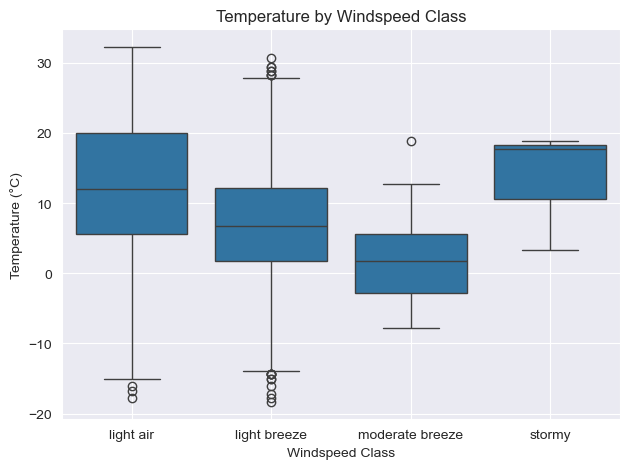

In [203]:
# Boxplot: Temperature by Windspeed Class
sns.boxplot(data=weather_data_raw, x='windspeed_class', y='temp_C')
plt.title("Temperature by Windspeed Class")
plt.xlabel("Windspeed Class")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

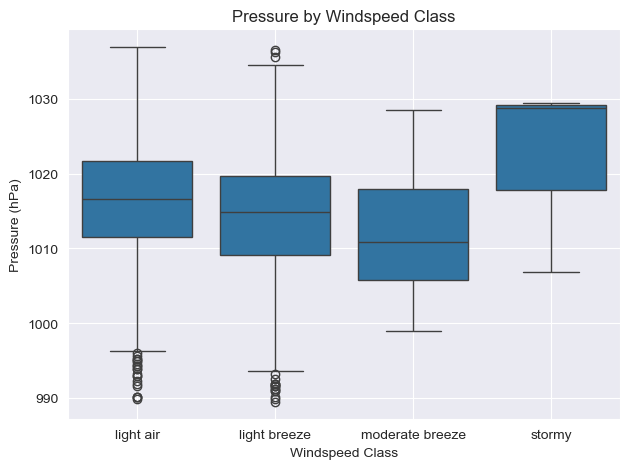

In [204]:
# Boxplot: Pressure by Windspeed Class
sns.boxplot(data=weather_data_raw, x='windspeed_class', y='pressure_hPa')
plt.title("Pressure by Windspeed Class")
plt.xlabel("Windspeed Class")
plt.ylabel("Pressure (hPa)")
plt.grid(True)
plt.tight_layout()
plt.show()

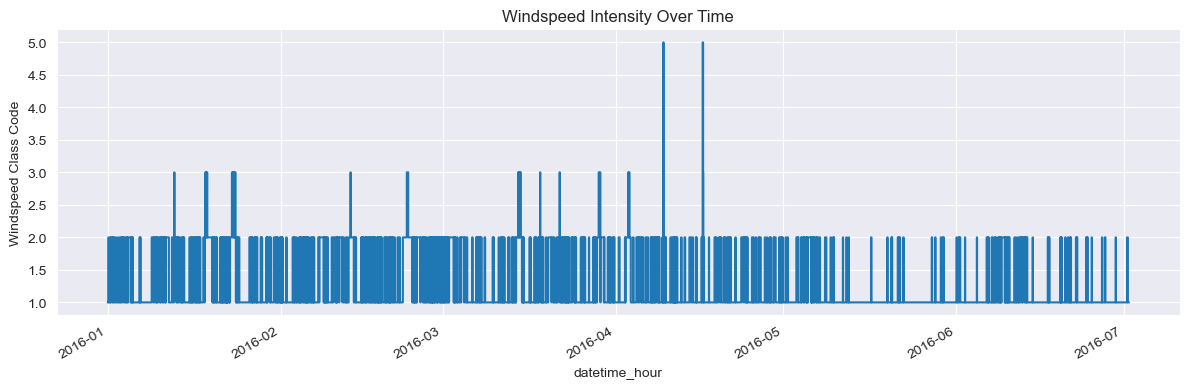

In [205]:
# Time series: Windspeed Class Code over Time
plt.figure(figsize=(12, 4))
weather_data_raw.set_index('datetime_hour')['windspeed_class_code'].plot(drawstyle='steps-post')
plt.title("Windspeed Intensity Over Time")
plt.ylabel("Windspeed Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

## Classify / EDA –  humidity itensity

In [206]:
def classify_humidity(h):
  if h <= 30:
    return 'very_dry'
  elif h <= 50:
    return 'dry'
  elif h <= 70:
    return 'normal'
  elif h <= 85:
    return 'wet'
  else:
    return 'very_wet'


weather_data_raw['humidity_class'] = weather_data_raw['humidity'].apply(classify_humidity)

In [207]:
humidity_mapping = {
  'very_dry': 0,
  'dry': 1,
  'normal': 2,
  'wet': 3,
  'very_wet': 4
}
weather_data_raw['humidity_class_code'] = weather_data_raw['humidity_class'].map(humidity_mapping)

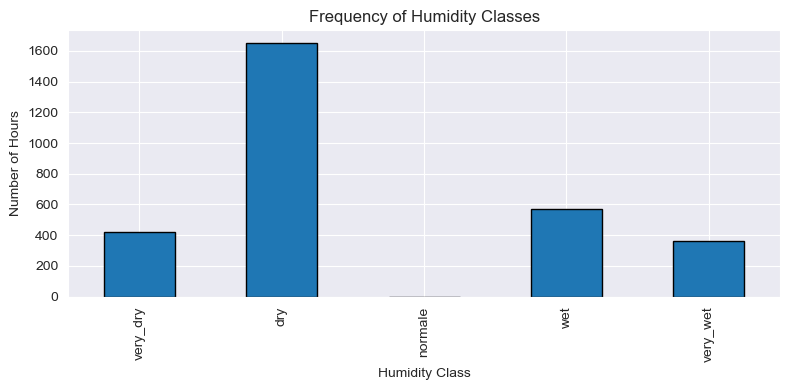

In [208]:
# Bar plot: Frequency of Humidity Classes
humidity_counts = weather_data_raw['humidity_class'].value_counts().reindex([
  'very_dry', 'dry', 'normale', 'wet', 'very_wet'
])

humidity_counts.plot(kind='bar', edgecolor='black', figsize=(8, 4))
plt.title("Frequency of Humidity Classes")
plt.xlabel("Humidity Class")
plt.ylabel("Number of Hours")
plt.grid(True)
plt.tight_layout()
plt.show()

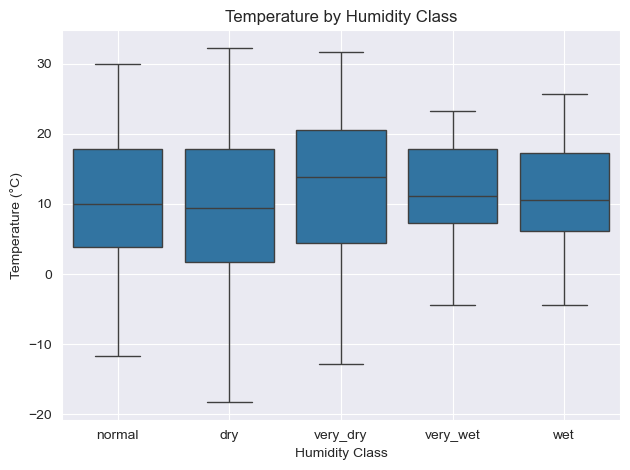

In [209]:

# Boxplot: Temperature by Humidity Class
sns.boxplot(data=weather_data_raw, x='humidity_class', y='temp_C')
plt.title("Temperature by Humidity Class")
plt.xlabel("Humidity Class")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

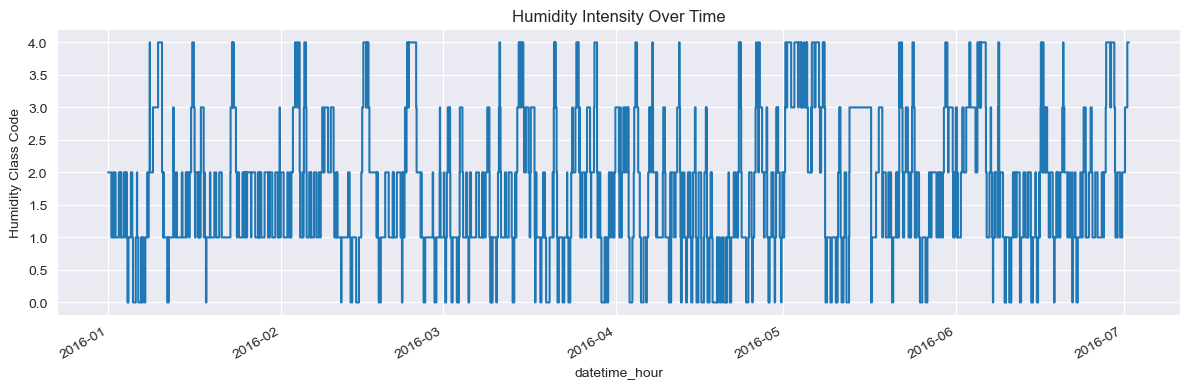

In [210]:

# Time series: Humidity Class Code over Time
plt.figure(figsize=(12, 4))
weather_data_raw.set_index('datetime_hour')['humidity_class_code'].plot(drawstyle='steps-post')
plt.title("Humidity Intensity Over Time")
plt.ylabel("Humidity Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

## Classify / EDA –  pressure itensity

In [211]:
def classify_pressure_label(p):
  if p < 980:
    return "very low"
  elif p < 1000:
    return "low"
  elif p < 1020:
    return "normal"
  elif p < 1030:
    return "high"
  else:
    return "very high"


weather_data_raw['pressure_class'] = weather_data_raw['pressure_hPa'].apply(classify_pressure_label)

In [212]:

pressure_mapping = {
  "very low": 0,
  "low": 1,
  "normal": 2,
  "high": 3,
  "very high": 4
}

weather_data_raw['pressure_class_code'] = weather_data_raw['pressure_class'].map(pressure_mapping)

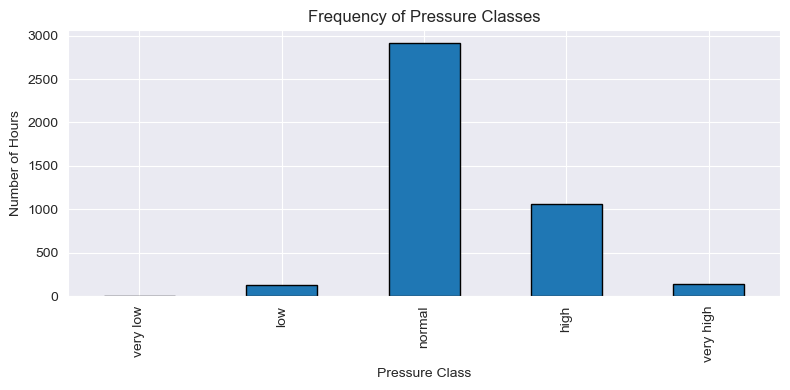

In [213]:
# Bar plot: Frequency of Pressure Classes
pressure_counts = weather_data_raw['pressure_class'].value_counts().reindex([
  "very low", "low", "normal", "high", "very high"
])

pressure_counts.plot(kind='bar', edgecolor='black', figsize=(8, 4))
plt.title("Frequency of Pressure Classes")
plt.xlabel("Pressure Class")
plt.ylabel("Number of Hours")
plt.grid(True)
plt.tight_layout()
plt.show()

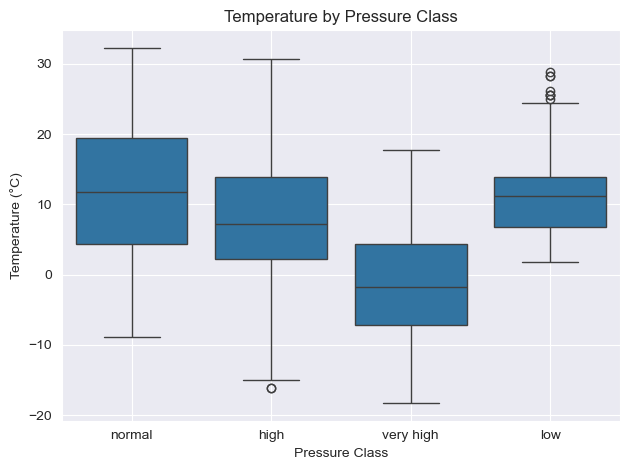

In [214]:

# Boxplot: Temperature by Pressure Class
sns.boxplot(data=weather_data_raw, x='pressure_class', y='temp_C')
plt.title("Temperature by Pressure Class")
plt.xlabel("Pressure Class")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

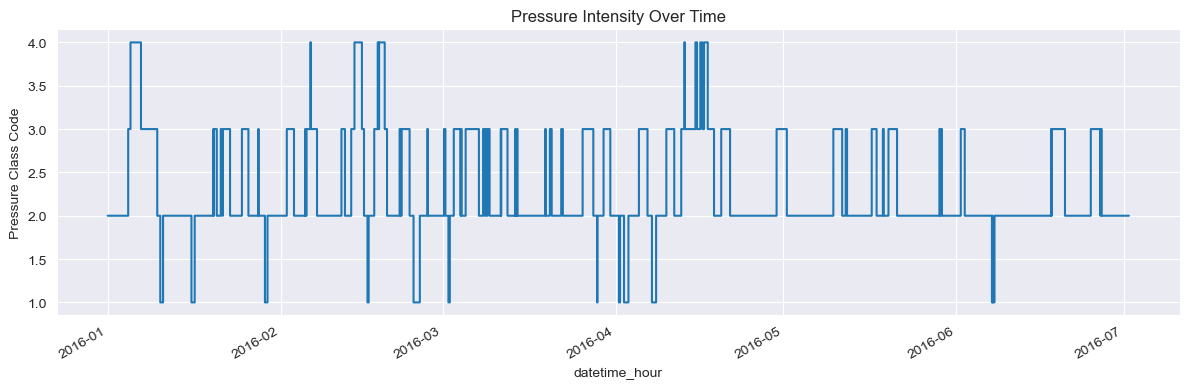

In [215]:

# Time series: Pressure Class Code over Time
plt.figure(figsize=(12, 4))
weather_data_raw.set_index('datetime_hour')['pressure_class_code'].plot(drawstyle='steps-post')
plt.title("Pressure Intensity Over Time")
plt.ylabel("Pressure Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

# Save Weather Data

In [216]:
weather_data_raw.to_csv("data/weather_data_clean.csv", index=False)